In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import Levenshtein
from PIL import Image
from torchtext.vocab import Vocab
import torch
from torch import nn
!pip install torch torchvision
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader

In [51]:
!pip install git+https://github.com/openai/CLIP.git 
import clip

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-546k5y6f
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-546k5y6f
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=ee0a2c20758816675db4a5c07672c5ac2867cdabc7016cd0a80d6e2e8a529b1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqq5gwct/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


#### Reading Data

In [2]:
train_json = open('/kaggle/input/vizwiz/Annotations/Annotations/train.json')
val_json = open('/kaggle/input/vizwiz/Annotations/Annotations/val.json')
test_json = open('/kaggle/input/vizwiz/Annotations/Annotations/test.json')
train_data = json.load(train_json)
val_data = json.load(val_json)

In [3]:
train_data[0]

{'image': 'VizWiz_train_00000000.jpg',
 'question': "What's the name of this product?",
 'answers': [{'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil'},
  {'answer_confidence': 'yes', 'answer': 'basil'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil leaves'},
  {'answer_confidence': 'yes', 'answer': 'basil'}],
 'answer_type': 'other',
 'answerable': 1}

In [4]:
def make_df(data,kind):
    image_paths=[]
    questions=[]
    answer_list=[]
    conf_list=[]
    ans_type=[]
    answerable=[]
    from tqdm import tqdm
    for entry in tqdm(data):
        image_id = entry['image']
        if kind == 1:
            path = "/kaggle/input/vizwiz/train/train/" + image_id
        else :
            path = "/kaggle/input/vizwiz/val/val/" + image_id
        image_paths.append(path)
        question = entry['question']
        questions.append(question)
        anstype = entry['answer_type']
        ans_type.append(anstype)
        answ1 = entry['answerable']
        answerable.append(answ1)
        answers = entry['answers']

        answer_scores = {}  # Track scores for each answer
        conf_scores = {}

        # Calculate scores for each answer
        for answer_entry in answers:
            answer = answer_entry['answer']
            answer_scores[answer] = answer_scores.get(answer, 0) + 1

            conf = answer_entry['answer_confidence']
            conf_scores[conf] = conf_scores.get(conf, 0) + 1

        # Select the answer with the highest score
        best_answer = max(answer_scores, key=answer_scores.get)
        best_conf = max(conf_scores, key=conf_scores.get)
        answer_list.append(best_answer)
        conf_list.append(best_conf)
        
        data_df = {
        'image_path': image_paths,
        'question': questions,
        'answer_confidence': conf_list,
        'answer_type': ans_type,
        'answerable' : answerable,
        'answer' : answer_list
        }

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(data_df)
    return df

In [5]:
train_df=make_df(train_data,1)
val_df=make_df(val_data,2)

100%|██████████| 4319/4319 [00:00<00:00, 94691.28it/s]


In [6]:
train_df

,image_path,question,answer_confidence,answer_type,answerable,answer
0,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What's the name of this product?,yes,other,1,basil leaves
1,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Can you tell me what is in this can please?,yes,other,1,coca cola
2,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Is this enchilada sauce or is this tomatoes? ...,yes,other,1,tomatoes
3,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is the captcha on this screenshot?,yes,other,1,t36m
4,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is this item?,yes,other,1,solar garden light
...,...,...,...,...,...,...
20518,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What's the color for this laptop?,yes,other,1,black
20519,/kaggle/input/vizwiz/train/train/VizWiz_train_...,"(inaudible) can you see it? If so, then tell m...",maybe,other,1,unanswerable
20520,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What are the three numbers I have to type?,maybe,unanswerable,0,unsuitable image
20521,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Is it a box?,yes,yes/no,1,no


In [7]:
val_df

,image_path,question,answer_confidence,answer_type,answerable,answer
0,/kaggle/input/vizwiz/val/val/VizWiz_val_000000...,Ok. There is another picture I hope it is a be...,yes,unanswerable,0,unanswerable
1,/kaggle/input/vizwiz/val/val/VizWiz_val_000000...,Can you tell me what this medicine is please?,maybe,other,1,night time
2,/kaggle/input/vizwiz/val/val/VizWiz_val_000000...,What is the title of this book?,yes,other,1,dog years
3,/kaggle/input/vizwiz/val/val/VizWiz_val_000000...,Which one is the blue one?,yes,other,1,right
4,/kaggle/input/vizwiz/val/val/VizWiz_val_000000...,What does the arrow say?,yes,unanswerable,0,unanswerable
...,...,...,...,...,...,...
4314,/kaggle/input/vizwiz/val/val/VizWiz_val_000043...,what is this?,yes,other,1,salad dressing
4315,/kaggle/input/vizwiz/val/val/VizWiz_val_000043...,Is this modern?,yes,unanswerable,0,unsuitable
4316,/kaggle/input/vizwiz/val/val/VizWiz_val_000043...,I need to buy this battery for my cordless pho...,yes,unanswerable,0,unanswerable
4317,/kaggle/input/vizwiz/val/val/VizWiz_val_000043...,What kind of mix is this?,yes,other,1,cake


In [8]:
data_df = pd.concat((train_df,val_df), axis =0,ignore_index=True)
data_df

,image_path,question,answer_confidence,answer_type,answerable,answer
0,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What's the name of this product?,yes,other,1,basil leaves
1,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Can you tell me what is in this can please?,yes,other,1,coca cola
2,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Is this enchilada sauce or is this tomatoes? ...,yes,other,1,tomatoes
3,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is the captcha on this screenshot?,yes,other,1,t36m
4,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is this item?,yes,other,1,solar garden light
...,...,...,...,...,...,...
24837,/kaggle/input/vizwiz/val/val/VizWiz_val_000043...,what is this?,yes,other,1,salad dressing
24838,/kaggle/input/vizwiz/val/val/VizWiz_val_000043...,Is this modern?,yes,unanswerable,0,unsuitable
24839,/kaggle/input/vizwiz/val/val/VizWiz_val_000043...,I need to buy this battery for my cordless pho...,yes,unanswerable,0,unanswerable
24840,/kaggle/input/vizwiz/val/val/VizWiz_val_000043...,What kind of mix is this?,yes,other,1,cake


## Plots

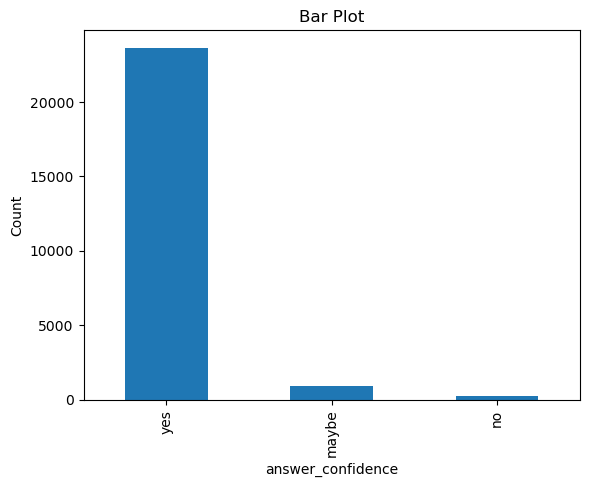

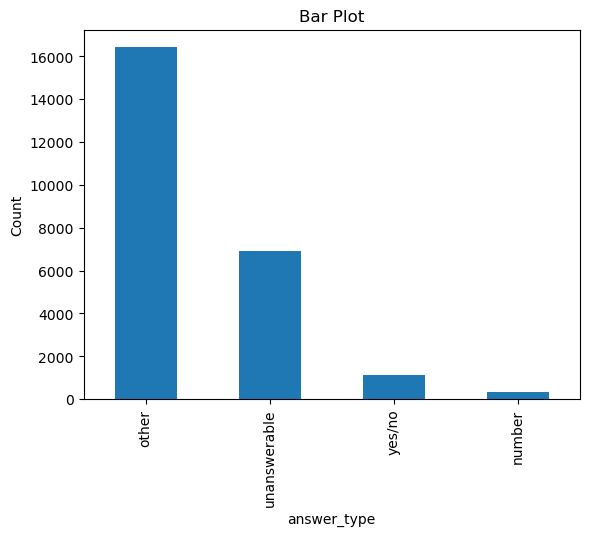

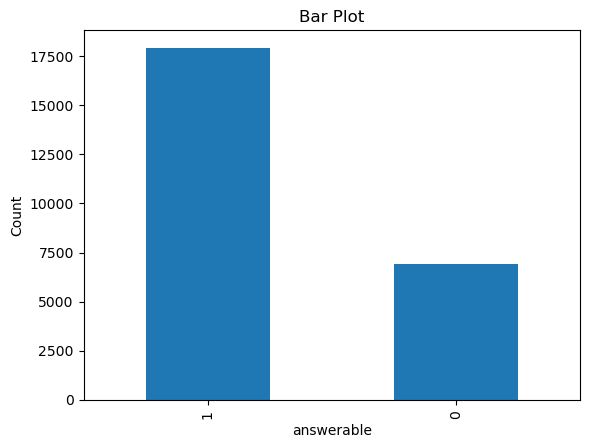

In [9]:
import matplotlib.pyplot as plt
value_counts = data_df['answer_confidence'].value_counts()
value_counts.plot(kind='bar')
plt.xlabel('answer_confidence')
plt.ylabel('Count')
plt.title('Bar Plot')
plt.show()
value_counts = data_df['answer_type'].value_counts()
value_counts.plot(kind='bar')
plt.xlabel('answer_type')
plt.ylabel('Count')
plt.title('Bar Plot')
plt.show()
value_counts = data_df['answerable'].value_counts()
value_counts.plot(kind='bar')
plt.xlabel('answerable')
plt.ylabel('Count')
plt.title('Bar Plot')
plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
ans_lb = LabelEncoder()
data_df['answer'] = ans_lb.fit_transform(data_df['answer'])
ans_type_lb = LabelEncoder()
data_df['answer_type']= ans_type_lb.fit_transform(data_df['answer_type'])

In [ ]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm

In [12]:
from PIL import Image
from tqdm import tqdm
encodings=[]
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)
for pic , question in tqdm(zip(data_df['image_path'],data_df['question'])):
    image = preprocess(Image.open(pic)).unsqueeze(0).to(device)
    text = clip.tokenize(question).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
    encodings.append(torch.cat([image_features, text_features], dim=-1))

100%|████████████████████████████████████████| 890M/890M [00:04<00:00, 206MiB/s]
24842it [36:00, 11.50it/s]


In [ ]:
torch.save(encodings,'encoding_2.pt')

In [11]:
encodings=torch.load('/kaggle/input/total-encoding-2/encoding_2.pt')

In [12]:
encs=torch.cat(encodings)

In [13]:
val_encs=encs[24842-4319:]

In [14]:
val = data_df.iloc[24842-4319:].reset_index(drop=True)

In [15]:
# Generate the indices for train-test split
indices = np.arange(20523)

# Perform train-test split
train_indices, test_indices = train_test_split(indices, test_size=0.05, random_state=42, stratify=data_df.iloc[:20523]['answer_type'])

In [16]:
train = data_df.iloc[train_indices] 
train = train.reset_index(drop=True)
train

,image_path,question,answer_confidence,answer_type,answerable,answer
0,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is this?,yes,1,1,5923
1,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What product is this? Is it moisturizing lotion?,yes,1,1,6453
2,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What's in this box?,yes,2,0,6033
3,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is in this kitchen? In this room?,yes,1,1,2536
4,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Is this shampoo or conditioner?,yes,1,1,5186
...,...,...,...,...,...,...
19491,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What number is shown?,yes,0,1,233
19492,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Where is B?,yes,1,1,3658
19493,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What kind of tea is this?,yes,1,1,4276
19494,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is this?,yes,1,1,1650


In [17]:
test = data_df.iloc[test_indices]
test = test.reset_index(drop=True)
test

,image_path,question,answer_confidence,answer_type,answerable,answer
0,/kaggle/input/vizwiz/train/train/VizWiz_train_...,Sometimes they're able to and sometimes they a...,yes,2,0,6033
1,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is the title of this book? Thank you,yes,2,0,6033
2,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What color is this?,yes,1,1,4565
3,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What's being displayed on my screen?,maybe,1,1,402
4,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is this item?,yes,1,1,2906
...,...,...,...,...,...,...
1022,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What flavor of kool aid is this?,yes,1,1,5977
1023,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is this item?,yes,1,1,4891
1024,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is the name of this book? Thank you.,yes,1,1,3639
1025,/kaggle/input/vizwiz/train/train/VizWiz_train_...,What is this?,yes,1,1,6362


In [18]:
n_classes=len(np.unique(ans_lb.classes_))
n_classes

6503

In [19]:
len(encs)

24842

In [20]:
class myDataset(Dataset):
    def __init__(self, pairs,answers,answer_type):
        self.pairs = pairs
        self.answers = answers
        self.answer_type = answer_type
      # stuff

    def __getitem__(self, index):
        return self.pairs[index].float(), torch.tensor(int(self.answers[index])) , torch.tensor(int(self.answer_type[index])) 

    def __len__(self):
        return len(self.pairs) 

In [30]:
trainDataset=myDataset(encs[train_indices],train['answer'], train['answer_type'])
valDataset=myDataset(val_encs,val['answer'], val['answer_type'])
train_dataloader = DataLoader(trainDataset, batch_size=64, num_workers=0)
val_dataloader = DataLoader(valDataset, batch_size=64, num_workers=0)

In [31]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.ln1 = torch.nn.LayerNorm(1536)
        self.dp1 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(1536, 512)
        
        self.ln2 = torch.nn.LayerNorm(512)
        self.dp2 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(512, n_classes)
        
        self.fc_aux = torch.nn.Linear(512, 4)
        self.fc_gate = torch.nn.Linear(4, n_classes)
        self.act_gate = torch.nn.Sigmoid()

    def forward(self, combined_encoding):
        x = self.ln1(combined_encoding)
        x = self.dp1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        aux = self.fc_aux(x)

        gate = self.fc_gate(aux)        
        gate = self.act_gate(gate)
         
        x = self.ln2(x)
        x = self.dp2(x)
        vqa = self.fc2(x)
        output = vqa * gate
        
        return output, aux

In [41]:
def run_model(model,dataloader,val_loader, optimizer,train = True ):
    if train:
        model.train()
    
    loss = nn.CrossEntropyLoss()
    
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    total_correct_ty = 0
    total_samples_ty = 0
    
    for (data, ans , ans_type) in tqdm(dataloader):
        data = data.to(device)
        ans = ans.to(device)
        ans_type = ans_type.to(device)
        optimizer.zero_grad()
        output , aux = model(data)
        
        loss_ans = loss(output, ans)
        loss_type = loss(aux,ans_type)
        loss_combined=loss_ans+loss_type
        total_loss += loss_combined.item()
        loss_combined.backward()
        optimizer.step()
        
        
#         Answer Accurracy
        _, predicted_labels = torch.max(output, dim=1)
        correct = (predicted_labels == ans).sum().item()
        total_correct += correct
        total_samples += ans.size(0)
        train_accuracy = total_correct / total_samples
        
#         Type Accuracy
        _, predicted_labels_ty = torch.max(aux, dim=1)
        correct_ty = (predicted_labels_ty == ans_type).sum().item()
        total_correct_ty += correct_ty
        total_samples_ty += ans_type.size(0)
        train_accuracy_ty = total_correct_ty / total_samples_ty
    
    total_train_accuracy = (train_accuracy + train_accuracy_ty) / 2
        
        
    if val_loader is not None:
        model.eval()

    # Initialize validation-specific variables
    val_loss = 0.0
    total_correct_val=0
    total_samples_val=0
    
    total_correct_val_ty=0
    total_samples_val_ty=0
    
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the validation data
        for (data, ans , ans_type) in val_loader:
            data = data.to(device)
            ans = ans.to(device)
            ans_type = ans_type.to(device)
            
            # Forward pass
            output , aux = model(data)

            # Compute the loss
            loss_ans = loss(output, ans)
            loss_type = loss(aux,ans_type)
            loss_combined=loss_ans+loss_type
            val_loss += loss_combined.item()

            # Update validation metrics
            _, val_predicted = torch.max(output, dim=1)
            correct_val = (val_predicted == ans).sum().item()
            total_correct_val += correct_val
            total_samples_val += ans.size(0)
            val_accuracy = total_correct_val / total_samples_val
            
            _, val_predicted_ty = torch.max(aux, dim=1)
            correct_val_ty = (val_predicted_ty == ans_type).sum().item()
            total_correct_val_ty += correct_val_ty
            total_samples_val_ty += ans_type.size(0)
            val_accuracy_ty = total_correct_val_ty / total_samples_val_ty
        
        total_val_accuracy = (val_accuracy + val_accuracy_ty) / 2
        
    train_loss = total_loss/len(dataloader)
    val_loss = val_loss/len(val_loader)
    
    print(f"\nTrain Loss: {train_loss:.4f} | AVG Train ACC: {total_train_accuracy * 100:.4f}% | Val Loss: {val_loss:.4f} | AVG Val ACC: {total_val_accuracy * 100:.2f}%")
    
    print(f"\nTrain ANS ACC: {train_accuracy * 100:.4f} | VAL ANS ACC: {val_accuracy * 100:.4f}% | Train TYPE ACC: {train_accuracy_ty * 100:.4f} | VAL TYPE ACC: {val_accuracy_ty * 100:.2f}%\n")
        
    return train_loss, val_loss

In [42]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model()
model = model.to(device)
model = nn.DataParallel(model)

epoch = 50
training_loss = []
val_loss = []

optimizer = torch.optim.Adam(model.parameters(),5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=.1, threshold=1e-6)

early_stopping_patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

for e in range(epoch):
    print(f'Epoch: {e+1}', f'| LR: { optimizer.param_groups[0]["lr"] }')
    trLoss, vlLoss = run_model(model,train_dataloader,val_dataloader,optimizer)    
    training_loss.append(trLoss)
    val_loss.append(vlLoss)
    
    scheduler.step(vlLoss)
    
    # Check if validation loss has improved
    if vlLoss < best_val_loss:
        best_val_loss = vlLoss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Check if early stopping criteria met
    if epochs_without_improvement >= early_stopping_patience:
        print(f"\nValidation loss hasn't improved for {early_stopping_patience} epochs. Early stopping.")
        break

Epoch: 1 | LR: 0.0005


100%|██████████| 305/305 [00:03<00:00, 79.04it/s]



Train Loss: 6.6696 | AVG Train ACC: 48.2612% | Val Loss: 6.0020 | AVG Val ACC: 52.18%

Train ANS ACC: 23.1791 | VAL ANS ACC: 27.3443% | Train TYPE ACC: 73.3432 | VAL TYPE ACC: 77.01%

Epoch: 2 | LR: 0.0005


100%|██████████| 305/305 [00:03<00:00, 81.25it/s]



Train Loss: 5.7676 | AVG Train ACC: 52.0543% | Val Loss: 5.8804 | AVG Val ACC: 52.71%

Train ANS ACC: 27.3646 | VAL ANS ACC: 28.6177% | Train TYPE ACC: 76.7439 | VAL TYPE ACC: 76.80%

Epoch: 3 | LR: 0.0005


100%|██████████| 305/305 [00:04<00:00, 75.21it/s]



Train Loss: 5.2920 | AVG Train ACC: 53.6777% | Val Loss: 5.9073 | AVG Val ACC: 53.25%

Train ANS ACC: 30.2934 | VAL ANS ACC: 30.6321% | Train TYPE ACC: 77.0620 | VAL TYPE ACC: 75.87%

Epoch: 4 | LR: 0.0005


100%|██████████| 305/305 [00:03<00:00, 79.52it/s]



Train Loss: 4.8405 | AVG Train ACC: 55.0651% | Val Loss: 6.0062 | AVG Val ACC: 54.14%

Train ANS ACC: 32.5503 | VAL ANS ACC: 31.5582% | Train TYPE ACC: 77.5800 | VAL TYPE ACC: 76.73%

Epoch: 5 | LR: 0.0005


100%|██████████| 305/305 [00:03<00:00, 82.45it/s]



Train Loss: 4.4111 | AVG Train ACC: 56.3475% | Val Loss: 5.8182 | AVG Val ACC: 54.78%

Train ANS ACC: 35.0687 | VAL ANS ACC: 32.5307% | Train TYPE ACC: 77.6262 | VAL TYPE ACC: 77.03%

Epoch: 6 | LR: 0.0005


100%|██████████| 305/305 [00:03<00:00, 81.33it/s]



Train Loss: 3.9866 | AVG Train ACC: 57.9093% | Val Loss: 6.0170 | AVG Val ACC: 55.19%

Train ANS ACC: 37.5923 | VAL ANS ACC: 32.9243% | Train TYPE ACC: 78.2263 | VAL TYPE ACC: 77.45%

Epoch: 7 | LR: 0.0005


100%|██████████| 305/305 [00:03<00:00, 82.10it/s]



Train Loss: 3.6042 | AVG Train ACC: 59.1275% | Val Loss: 6.2056 | AVG Val ACC: 55.61%

Train ANS ACC: 40.4339 | VAL ANS ACC: 33.9199% | Train TYPE ACC: 77.8211 | VAL TYPE ACC: 77.31%

Epoch: 8 | LR: 0.0005


100%|██████████| 305/305 [00:03<00:00, 81.38it/s]



Train Loss: 3.2312 | AVG Train ACC: 60.9843% | Val Loss: 6.2397 | AVG Val ACC: 55.68%

Train ANS ACC: 43.7680 | VAL ANS ACC: 34.2440% | Train TYPE ACC: 78.2007 | VAL TYPE ACC: 77.12%

Epoch: 9 | LR: 0.0005


100%|██████████| 305/305 [00:03<00:00, 82.00it/s]



Train Loss: 2.9090 | AVG Train ACC: 62.6205% | Val Loss: 6.5212 | AVG Val ACC: 55.38%

Train ANS ACC: 47.2046 | VAL ANS ACC: 34.2903% | Train TYPE ACC: 78.0365 | VAL TYPE ACC: 76.48%

Epoch: 10 | LR: 0.0005


100%|██████████| 305/305 [00:04<00:00, 74.50it/s]



Train Loss: 2.5927 | AVG Train ACC: 64.9518% | Val Loss: 6.5362 | AVG Val ACC: 56.23%

Train ANS ACC: 51.5183 | VAL ANS ACC: 35.3554% | Train TYPE ACC: 78.3853 | VAL TYPE ACC: 77.10%

Epoch: 11 | LR: 0.0005


100%|██████████| 305/305 [00:03<00:00, 80.55it/s]



Train Loss: 2.3664 | AVG Train ACC: 66.2161% | Val Loss: 6.6961 | AVG Val ACC: 56.23%

Train ANS ACC: 54.5189 | VAL ANS ACC: 35.7490% | Train TYPE ACC: 77.9134 | VAL TYPE ACC: 76.71%

Epoch: 12 | LR: 5e-05


100%|██████████| 305/305 [00:03<00:00, 81.83it/s]



Train Loss: 2.0824 | AVG Train ACC: 69.4527% | Val Loss: 6.7821 | AVG Val ACC: 56.99%

Train ANS ACC: 59.7456 | VAL ANS ACC: 36.3510% | Train TYPE ACC: 79.1598 | VAL TYPE ACC: 77.63%

Epoch: 13 | LR: 5e-05


100%|██████████| 305/305 [00:03<00:00, 81.06it/s]



Train Loss: 2.0003 | AVG Train ACC: 70.0067% | Val Loss: 6.8070 | AVG Val ACC: 57.02%

Train ANS ACC: 61.1356 | VAL ANS ACC: 36.3510% | Train TYPE ACC: 78.8777 | VAL TYPE ACC: 77.68%

Epoch: 14 | LR: 5e-05


100%|██████████| 305/305 [00:03<00:00, 82.22it/s]



Train Loss: 1.9687 | AVG Train ACC: 70.3170% | Val Loss: 6.7687 | AVG Val ACC: 56.91%

Train ANS ACC: 61.6178 | VAL ANS ACC: 36.2121% | Train TYPE ACC: 79.0162 | VAL TYPE ACC: 77.61%

Epoch: 15 | LR: 5e-05


100%|██████████| 305/305 [00:03<00:00, 81.05it/s]



Train Loss: 1.9189 | AVG Train ACC: 70.8504% | Val Loss: 6.7747 | AVG Val ACC: 56.93%

Train ANS ACC: 62.6180 | VAL ANS ACC: 36.3510% | Train TYPE ACC: 79.0829 | VAL TYPE ACC: 77.52%


Validation loss hasn't improved for 10 epochs. Early stopping.


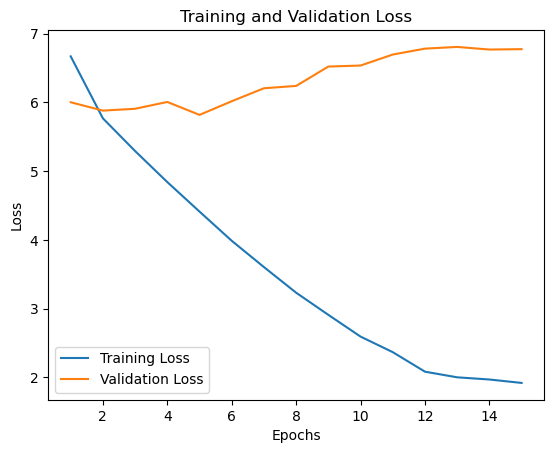

In [43]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Assuming you have two lists: train_loss and val_loss
plot_loss(training_loss, val_loss)

In [44]:
testDataset=myDataset(encs[test_indices],test['answer'], test['answer_type'])
test_dataloader = DataLoader(testDataset, batch_size=32,shuffle=True, num_workers=0)

In [49]:
loss = nn.CrossEntropyLoss()
model.eval()

test_loss = 0.0
total_correct_test=0
total_samples_test=0
    
total_correct_test_ty=0
total_samples_test_ty=0

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the validation data
    for (data, ans , ans_type) in test_dataloader:
            data = data.to(device)
            ans = ans.to(device)
            ans_type = ans_type.to(device)
            # Forward pass
            output , aux = model(data)

            # Compute the loss
            loss_ans = loss(output, ans)
            loss_type = loss(aux,ans_type)
            loss_combined=loss_ans+loss_type
            test_loss += loss_combined.item()

            # Update validation metrics
            _, test_predicted = torch.max(output, dim=1)
            correct_test = (test_predicted == ans).sum().item()
            total_correct_test += correct_test
            total_samples_test += ans.size(0)
            test_accuracy = total_correct_test / total_samples_test
            
            _, test_predicted_ty = torch.max(aux, dim=1)
            correct_test_ty = (test_predicted_ty == ans_type).sum().item()
            total_correct_test_ty += correct_test_ty
            total_samples_test_ty += ans_type.size(0)
            test_accuracy_ty = total_correct_test_ty / total_samples_test_ty
        
    total_test_accuracy = (test_accuracy + test_accuracy_ty) / 2
    
print(f"Test TYPE ACC: {test_accuracy_ty * 100:.4f}% | Test ANS ACC: {test_accuracy * 100:.4f}% | AVG Test ACC: {total_test_accuracy * 100:.4f}% | Test Loss: {test_loss:.4f}")

Test TYPE ACC: 79.2600% | Test ANS ACC: 39.9221% | AVG Test ACC: 59.5910% | Test Loss: 218.9413


In [50]:
torch.save(model.state_dict(), 'weights.pth')

### Un seen Image

In [52]:
model_clip, preprocess = clip.load("ViT-L/14", device=device)

100%|████████████████████████████████████████| 890M/890M [00:05<00:00, 156MiB/s]


In [61]:
model_clip, preprocess = clip.load("ViT-L/14", device=device)

In [64]:
def predict_image(image_path,question,model_clip,ans_lb,ans_type_lb,model):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Remove axis ticks and labels
    plt.show()
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize(question).to(device)

    with torch.no_grad():
        image_encoding = model_clip.encode_image(image)
        text_encoding = model_clip.encode_text(text)
    model.eval()
    with torch.no_grad():
        output , aux = model(torch.cat([image_encoding,text_encoding],dim= -1).float())
        _, unseen = torch.max(output, dim=1)
        _, unseen_type = torch.max(aux, dim=1)
    answer=ans_lb.inverse_transform([unseen.item()])
    ans_type=ans_type_lb.inverse_transform([unseen_type.item()])
    print("Answer : "+str(answer[0])+", Type : "+str(ans_type[0]))

## Personal Image

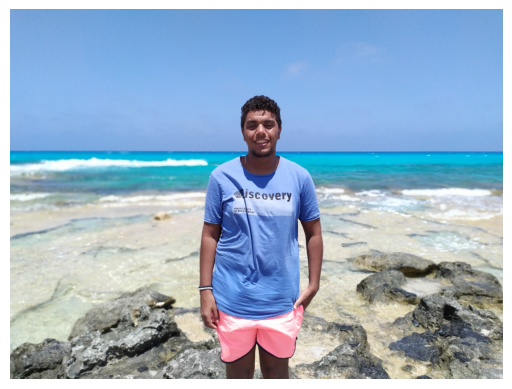

Answer : blue, Type : other


In [68]:
predict_image('/kaggle/input/mazenpic/IMG_20190803_121037.jpg','What is color?',model_clip,ans_lb,ans_type_lb,model)

### Public image

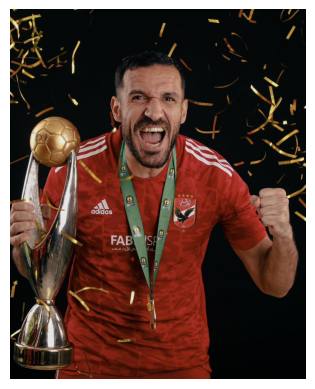

Answer : black, Type : other


In [74]:
predict_image('/kaggle/input/maaloul/347592693_842383953913356_1817087802609421467_n.jpg','What is background color?',model_clip,ans_lb,ans_type_lb,model)

### Taken by us

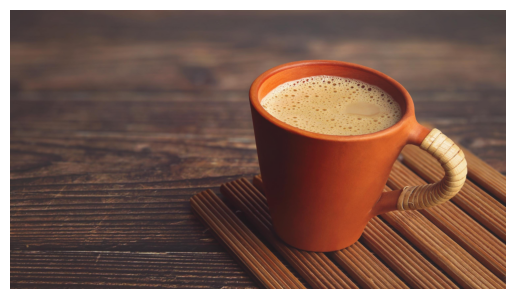

Answer : coffee cup, Type : other


In [84]:
predict_image('/kaggle/input/coffee/best_coffee_cup_-_lead_image.jpg','what is this?',model_clip,ans_lb,ans_type_lb,model)

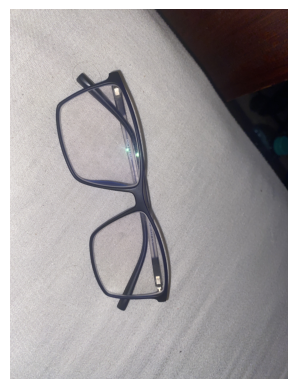

Answer : glasses, Type : other


In [80]:
predict_image('/kaggle/input/glasses/IMG_5419.jpg','What is this?',model_clip,ans_lb,ans_type_lb,model)

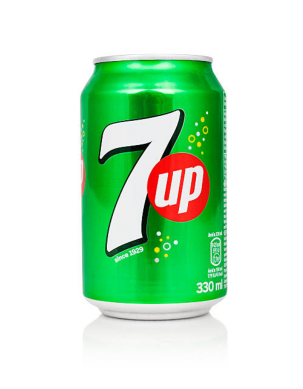

Answer : up, Type : other


In [89]:
predict_image('/kaggle/input/sevenup/istockphoto-531417466-612x612.jpg','What is this?',model_clip,ans_lb,ans_type_lb,model)

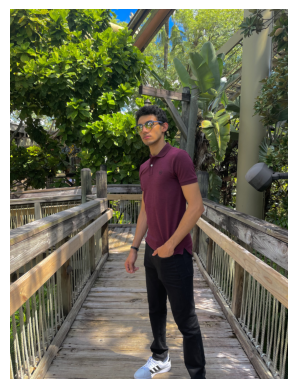

Answer : yes, Type : yes/no


In [90]:
predict_image('/kaggle/input/selmyy/selmy.jpg','is there sunglasses?',model_clip,ans_lb,ans_type_lb,model)

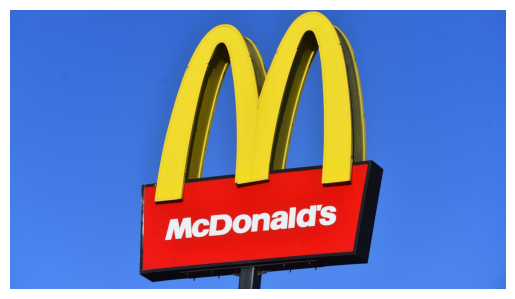

Answer : mcdonalds, Type : other


In [91]:
predict_image('/kaggle/input/mcdonalds/107180422-1674061950534-gettyimages-1285446341-dsc_2675_20201113110927535.jpeg','what is the brand?',model_clip,ans_lb,ans_type_lb,model)

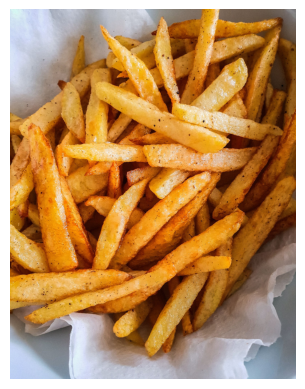

Answer : potato chips, Type : other


In [93]:
predict_image('/kaggle/input/frenchfries/licensed-image.jpeg','what is this?',model_clip,ans_lb,ans_type_lb,model)